# CONFLUENCE Tutorial: Elevation-Based HRU Discretization

This notebook demonstrates elevation-based HRU discretization, building on the distributed domain from Tutorial 3. We'll:

1. Use the existing GRUs from Tutorial 3
2. Apply elevation-based discretization
3. Run the model
4. Compare results with lumped and GRU-based approaches

**Prerequisites**: Tutorial 3 must be completed successfully.

## 1. Setup and Import Libraries

In [2]:
# Import required libraries
import sys
import os
from pathlib import Path
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from datetime import datetime
import numpy as np
import contextily as cx
import xarray as xr
import shutil
from IPython.display import Image, display

# Add CONFLUENCE to path
confluence_path = Path('../').resolve()
sys.path.append(str(confluence_path))

# Import main CONFLUENCE class
from CONFLUENCE import CONFLUENCE

# Set up plotting style
plt.style.use('default')
%matplotlib inline

## 2. Initialize CONFLUENCE
First, let's set up our directories and load the configuration. We'll modify the configuration from Tutorial 3 to use elevation-based discretization.

In [3]:
# Set directory paths
CONFLUENCE_CODE_DIR = confluence_path
CONFLUENCE_DATA_DIR = Path('/work/comphyd_lab/data/CONFLUENCE_data')  # ← User should modify this path

# Verify paths exist
if not CONFLUENCE_CODE_DIR.exists():
    raise FileNotFoundError(f"CONFLUENCE code directory not found: {CONFLUENCE_CODE_DIR}")

if not CONFLUENCE_DATA_DIR.exists():
    print(f"Data directory doesn't exist. Creating: {CONFLUENCE_DATA_DIR}")
    CONFLUENCE_DATA_DIR.mkdir(parents=True, exist_ok=True)

# Load the distributed configuration from Tutorial 3
distributed_config_path = CONFLUENCE_CODE_DIR / '0_config_files' / 'config_distributed.yaml'
if not distributed_config_path.exists():
    raise FileNotFoundError("Tutorial 3 must be run first! Distributed config file not found.")

# Read config file
with open(distributed_config_path, 'r') as f:
    config_dict = yaml.safe_load(f)

# Update core paths
config_dict['CONFLUENCE_CODE_DIR'] = str(CONFLUENCE_CODE_DIR)
config_dict['CONFLUENCE_DATA_DIR'] = str(CONFLUENCE_DATA_DIR)

# Modify for elevation-based discretization
config_dict['DOMAIN_NAME'] = 'Bow_at_Banff_elevation'
config_dict['EXPERIMENT_ID'] = 'elevation_tutorial'
config_dict['DOMAIN_DISCRETIZATION'] = 'elevation'  # Key change!
config_dict['ELEVATION_BAND_SIZE'] = 200  # 200m bands
config_dict['MIN_HRU_SIZE'] = 4  # 4 km² minimum
# Keep SPATIAL_MODE as 'Distributed'

# Save updated config to a temporary file
elevation_config_path = CONFLUENCE_CODE_DIR / '0_config_files' / 'config_elevation.yaml'
with open(elevation_config_path, 'w') as f:
    yaml.dump(config_dict, f)

# Initialize CONFLUENCE
confluence = CONFLUENCE(elevation_config_path)

# Display configuration
print("=== Directory Configuration ===")
print(f"Code Directory: {CONFLUENCE_CODE_DIR}")
print(f"Data Directory: {CONFLUENCE_DATA_DIR}")
print("\n=== Key Configuration Settings ===")
print(f"Domain Name: {confluence.config['DOMAIN_NAME']}")
print(f"Pour Point: {confluence.config['POUR_POINT_COORDS']}")
print(f"Discretization Method: {confluence.config['DOMAIN_DISCRETIZATION']}")
print(f"Elevation Band Size: {confluence.config['ELEVATION_BAND_SIZE']} m")
print(f"Minimum HRU Size: {confluence.config['MIN_HRU_SIZE']} km²")
print(f"Spatial Mode: {confluence.config['SPATIAL_MODE']}")
print(f"Model: {confluence.config['HYDROLOGICAL_MODEL']}")
print(f"Simulation Period: {confluence.config['EXPERIMENT_TIME_START']} to {confluence.config['EXPERIMENT_TIME_END']}")

20:04:25 - INFO - ============================================================


2025-05-11 20:04:25,265 - confluence_general - INFO - ============================================================


20:04:25 - INFO - CONFLUENCE Logging Initialized


2025-05-11 20:04:25,267 - confluence_general - INFO - CONFLUENCE Logging Initialized


20:04:25 - INFO - Domain: Bow_at_Banff_elevation


2025-05-11 20:04:25,270 - confluence_general - INFO - Domain: Bow_at_Banff_elevation


20:04:25 - INFO - Experiment ID: elevation_tutorial


2025-05-11 20:04:25,273 - confluence_general - INFO - Experiment ID: elevation_tutorial


20:04:25 - INFO - Log Level: INFO


2025-05-11 20:04:25,275 - confluence_general - INFO - Log Level: INFO


20:04:25 - INFO - Log File: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_elevation/_workLog_Bow_at_Banff_elevation/confluence_general_Bow_at_Banff_elevation_20250511_200425.log


2025-05-11 20:04:25,278 - confluence_general - INFO - Log File: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_elevation/_workLog_Bow_at_Banff_elevation/confluence_general_Bow_at_Banff_elevation_20250511_200425.log


20:04:25 - INFO - ============================================================


2025-05-11 20:04:25,281 - confluence_general - INFO - ============================================================


20:04:25 - INFO - Configuration logged to: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_elevation/_workLog_Bow_at_Banff_elevation/config_Bow_at_Banff_elevation_20250511_200425.yaml


2025-05-11 20:04:25,308 - confluence_general - INFO - Configuration logged to: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_elevation/_workLog_Bow_at_Banff_elevation/config_Bow_at_Banff_elevation_20250511_200425.yaml


20:04:25 - INFO - Initializing CONFLUENCE system


2025-05-11 20:04:25,315 - confluence_general - INFO - Initializing CONFLUENCE system


20:04:25 - INFO - Configuration loaded from: /home/darri.eythorsson/code/CONFLUENCE/0_config_files/config_elevation.yaml


2025-05-11 20:04:25,318 - confluence_general - INFO - Configuration loaded from: /home/darri.eythorsson/code/CONFLUENCE/0_config_files/config_elevation.yaml


20:04:25 - INFO - Initializing VariableHandler for dataset: ERA5 and model: SUMMA


2025-05-11 20:04:25,321 - confluence_general - INFO - Initializing VariableHandler for dataset: ERA5 and model: SUMMA


20:04:25 - INFO - CONFLUENCE system initialized successfully


2025-05-11 20:04:25,658 - confluence_general - INFO - CONFLUENCE system initialized successfully


=== Directory Configuration ===
Code Directory: /home/darri.eythorsson/code/CONFLUENCE
Data Directory: /work/comphyd_lab/data/CONFLUENCE_data

=== Key Configuration Settings ===
Domain Name: Bow_at_Banff_elevation
Pour Point: 51.1722/-115.5717
Discretization Method: elevation
Elevation Band Size: 200 m
Minimum HRU Size: 4 km²
Spatial Mode: Distributed
Model: SUMMA
Simulation Period: 2018-01-01 01:00 to 2018-12-31 23:00


## 3. Visualize Domain Discretization Approaches

Before we start building the elevation-based model, let's visualize the three approaches to domain discretization.

/tmp/ipykernel_620742/656964357.py:20: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle(pos, 0.15, fill=True, color=color, alpha=0.7, edgecolor='black')
/tmp/ipykernel_620742/656964357.py:48: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  band = plt.Circle(pos, size, fill=True, color=colors[j], alpha=0.7, edgecolor='gray')


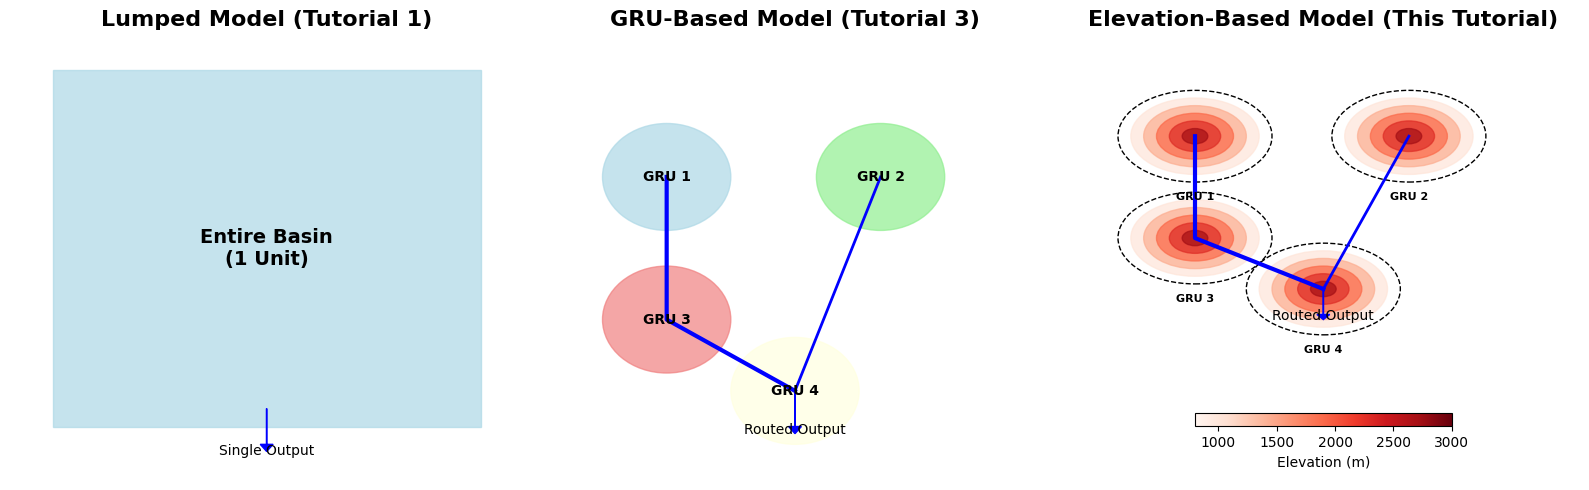

In [4]:
# Create visualization comparing approaches
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))

# Lumped representation (Tutorial 1)
ax1.add_patch(plt.Rectangle((0, 0), 1, 1, fill=True, color='lightblue', alpha=0.7))
ax1.text(0.5, 0.5, 'Entire Basin\n(1 Unit)', ha='center', va='center', fontsize=14, fontweight='bold')
ax1.arrow(0.5, 0.05, 0, -0.1, head_width=0.03, head_length=0.02, fc='blue', ec='blue')
ax1.text(0.5, -0.08, 'Single Output', ha='center', fontsize=10)
ax1.set_xlim(-0.1, 1.1)
ax1.set_ylim(-0.15, 1.1)
ax1.set_title('Lumped Model (Tutorial 1)', fontsize=16, fontweight='bold')
ax1.axis('off')

# Distributed GRU-based representation (Tutorial 3)
colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow']
positions = [(0.2, 0.7), (0.7, 0.7), (0.2, 0.3), (0.5, 0.1)]
labels = ['GRU 1', 'GRU 2', 'GRU 3', 'GRU 4']

for i, (pos, color, label) in enumerate(zip(positions, colors, labels)):
    circle = plt.Circle(pos, 0.15, fill=True, color=color, alpha=0.7, edgecolor='black')
    ax2.add_patch(circle)
    ax2.text(pos[0], pos[1], label, ha='center', va='center', fontsize=10, fontweight='bold')

# Draw river network
ax2.plot([0.2, 0.2, 0.5], [0.7, 0.3, 0.1], 'b-', linewidth=3)  # Main stem
ax2.plot([0.7, 0.5], [0.7, 0.1], 'b-', linewidth=2)  # Tributary
ax2.arrow(0.5, 0.1, 0, -0.1, head_width=0.03, head_length=0.02, fc='blue', ec='blue')
ax2.text(0.5, -0.02, 'Routed Output', ha='center', fontsize=10)

ax2.set_xlim(-0.1, 1.1)
ax2.set_ylim(-0.15, 1.1)
ax2.set_title('GRU-Based Model (Tutorial 3)', fontsize=16, fontweight='bold')
ax2.axis('off')

# Elevation-based representation (Tutorial 4)
# Create a more complex visualization showing elevation bands
positions = [(0.2, 0.7), (0.7, 0.7), (0.2, 0.3), (0.5, 0.1)]
gru_labels = ['GRU 1', 'GRU 2', 'GRU 3', 'GRU 4']
colors = ['#fee5d9', '#fcae91', '#fb6a4a', '#de2d26', '#a50f15']  # Red color gradient

for i, (pos, label) in enumerate(zip(positions, gru_labels)):
    # Draw the GRU
    circle = plt.Circle(pos, 0.18, fill=False, edgecolor='black', linestyle='--')
    ax3.add_patch(circle)
    
    # Draw elevation bands within each GRU (concentric circles)
    for j, size in enumerate([0.15, 0.12, 0.09, 0.06, 0.03]):
        band = plt.Circle(pos, size, fill=True, color=colors[j], alpha=0.7, edgecolor='gray')
        ax3.add_patch(band)
    
    ax3.text(pos[0], pos[1]-0.25, label, ha='center', fontsize=8, fontweight='bold')

# Draw river network
ax3.plot([0.2, 0.2, 0.5], [0.7, 0.3, 0.1], 'b-', linewidth=3)  # Main stem
ax3.plot([0.7, 0.5], [0.7, 0.1], 'b-', linewidth=2)  # Tributary
ax3.arrow(0.5, 0.1, 0, -0.1, head_width=0.03, head_length=0.02, fc='blue', ec='blue')
ax3.text(0.5, -0.02, 'Routed Output', ha='center', fontsize=10)

# Add color legend for elevation
cmap = plt.cm.Reds
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=800, vmax=3000))
sm._A = []
cbar = plt.colorbar(sm, ax=ax3, orientation='horizontal', pad=0.05, shrink=0.5)
cbar.set_label('Elevation (m)', fontsize=10)

ax3.set_xlim(-0.1, 1.1)
ax3.set_ylim(-0.3, 1.1)
ax3.set_title('Elevation-Based Model (This Tutorial)', fontsize=16, fontweight='bold')
ax3.axis('off')

plt.tight_layout()
plt.show()

## 4. Project Setup - Organizing the Modeling Workflow

First, we'll establish a well-organized project structure, similar to what we did in Tutorial 3.

In [5]:
# Step 1: Project Initialization
print("=== Step 1: Project Initialization ===")

# Setup project
project_dir = confluence.managers['project'].setup_project()

# List created directories
print("\nCreated directories:")
for item in sorted(project_dir.iterdir()):
    if item.is_dir():
        print(f"  📁 {item.name}")

=== Step 1: Project Initialization ===
20:04:26 - INFO - Setting up project for domain: Bow_at_Banff_elevation


2025-05-11 20:04:26,272 - confluence_general - INFO - Setting up project for domain: Bow_at_Banff_elevation


20:04:26 - INFO - Project directory created at: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_elevation


2025-05-11 20:04:26,342 - confluence_general - INFO - Project directory created at: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_elevation



Created directories:
  📁 _workLog_Bow_at_Banff_elevation
  📁 attributes
  📁 documentation
  📁 evaluation
  📁 forcing
  📁 observations
  📁 optimisation
  📁 plots
  📁 settings
  📁 shapefiles


## 5. Copy Domain Data from Tutorial 3

We'll reuse the existing domain and GRUs from Tutorial 3 (distributed model) instead of starting from scratch.

In [6]:
# Source domain from Tutorial 3
source_domain = CONFLUENCE_DATA_DIR / 'domain_Bow_at_Banff_distributed'

# Check if Tutorial 3 domain exists
if not source_domain.exists():
    raise FileNotFoundError("Tutorial 3 domain not found! Please run Tutorial 3 first.")

# Copy necessary directories from Tutorial 3
print("=== Step 2: Copying Domain Data from Tutorial 3 ===")
dirs_to_copy = ['shapefiles', 'attributes']

for dir_name in dirs_to_copy:
    source_dir = source_domain / dir_name
    target_dir = project_dir / dir_name
    
    if source_dir.exists():
        print(f"Copying {dir_name} from Tutorial 3...")
        # Create target directory if it doesn't exist
        target_dir.mkdir(parents=True, exist_ok=True)
        
        # Copy files
        for src_file in source_dir.glob('**/*'):
            if src_file.is_file():
                # Calculate relative path
                rel_path = src_file.relative_to(source_dir)
                dest_file = target_dir / rel_path
                
                # Create parent directories if needed
                dest_file.parent.mkdir(parents=True, exist_ok=True)
                
                # Copy the file, replacing 'distributed' with 'elevation' in filename
                shutil.copy2(src_file, dest_file)
                if 'distributed' in dest_file.name:
                    new_name = dest_file.parent / dest_file.name.replace('distributed', 'elevation')
                    dest_file.rename(new_name)
    else:
        print(f"Warning: {source_dir} not found in Tutorial 3 domain.")

print("\n✓ Domain data copied from Tutorial 3")

=== Step 2: Copying Domain Data from Tutorial 3 ===
Copying shapefiles from Tutorial 3...
Copying attributes from Tutorial 3...

✓ Domain data copied from Tutorial 3


## 6. Verify GRU Boundaries

Let's check the existing GRU boundaries that we'll use as a basis for our elevation-based HRUs.

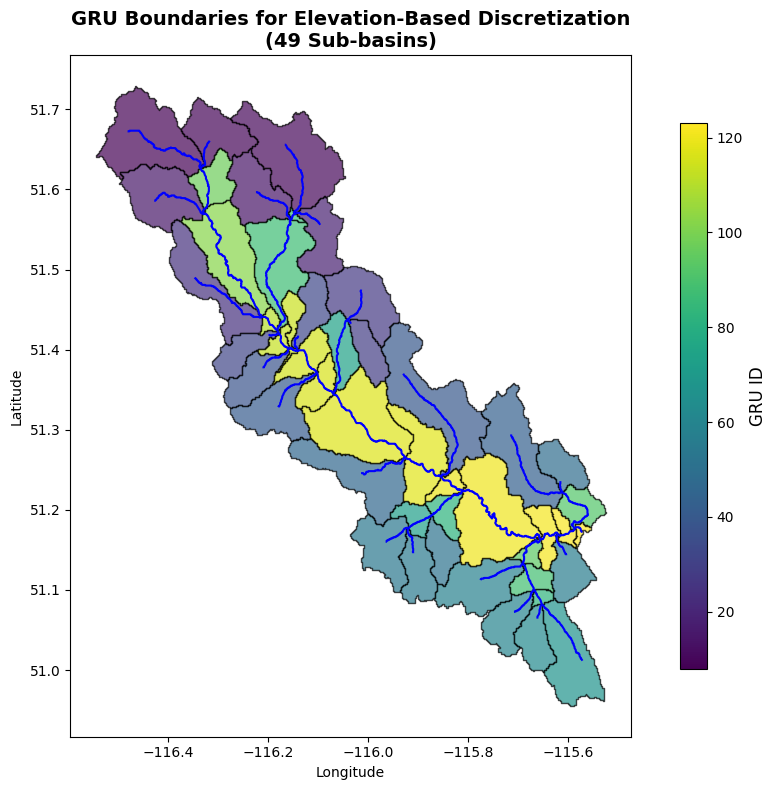

Number of GRUs: 49
Total area: 0.00 km²


/tmp/ipykernel_620742/1771678837.py:41: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  print(f"Total area: {basins.geometry.area.sum() / 1e6:.2f} km²")


In [7]:
# Check river basins (GRUs) and network
basin_path = project_dir / 'shapefiles' / 'river_basins'
network_path = project_dir / 'shapefiles' / 'river_network'

basin_files = list(basin_path.glob('*.shp'))
network_files = list(network_path.glob('*.shp'))

if basin_files and network_files:
    # Load data
    basins = gpd.read_file(basin_files[0])
    rivers = gpd.read_file(network_files[0])
    
    # Create visualization
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Plot basins (GRUs)
    basins.plot(ax=ax, column='GRU_ID', cmap='viridis', 
               alpha=0.7, edgecolor='black', linewidth=1)
    
    # Plot river network
    rivers.plot(ax=ax, color='blue', linewidth=1.5)
    
    # Format plot
    ax.set_title(f'GRU Boundaries for Elevation-Based Discretization\n({len(basins)} Sub-basins)', 
                fontsize=14, fontweight='bold')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    
    # Add colorbar for GRU IDs
    sm = plt.cm.ScalarMappable(cmap='viridis', 
                             norm=plt.Normalize(vmin=basins['GRU_ID'].min(), 
                                               vmax=basins['GRU_ID'].max()))
    sm._A = []
    cbar = fig.colorbar(sm, ax=ax, shrink=0.8)
    cbar.set_label('GRU ID', fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Number of GRUs: {len(basins)}")
    print(f"Total area: {basins.geometry.area.sum() / 1e6:.2f} km²")
else:
    print("GRU files not found. Make sure Tutorial 3 was completed successfully.")

## 7. Create Elevation-Based HRUs

Now we'll apply elevation-based discretization to create HRUs within each GRU.

In [8]:
# Step 3: Create Elevation-Based HRUs
print("=== Step 3: Creating Elevation-Based HRUs ===")
print(f"Discretization Method: {confluence.config['DOMAIN_DISCRETIZATION']}")
print(f"Elevation Band Size: {confluence.config['ELEVATION_BAND_SIZE']} m")
print(f"Minimum HRU Size: {confluence.config['MIN_HRU_SIZE']} km²")

# Apply discretization
print("\nApplying elevation-based discretization...")
hru_path = confluence.managers['domain'].discretize_domain()

# Load and analyze the resulting HRU shapefile
catchment_path = project_dir / 'shapefiles' / 'catchment'
if catchment_path.exists():
    hru_files = list(catchment_path.glob('*.shp'))
    if hru_files:
        hru_gdf = gpd.read_file(hru_files[0])
        
        # Store the GRU GeoDataFrame for later use
        gru_gdf = gpd.read_file(basin_files[0])
        
        print(f"\n✓ Created elevation-based HRUs")
        print(f"Number of HRUs: {len(hru_gdf)}")
        print(f"Number of GRUs: {hru_gdf['GRU_ID'].nunique()}")
        
        # Calculate HRUs per GRU
        hru_counts = hru_gdf.groupby('GRU_ID').size()
        avg_hrus_per_gru = hru_counts.mean()
        print(f"Average HRUs per GRU: {avg_hrus_per_gru:.1f}")
        
        # Show the first few GRUs with their HRU counts
        print("\nHRUs per GRU (first 10):")
        for gru_id, count in hru_counts.head(10).items():
            print(f"  GRU {gru_id}: {count} HRUs")
else:
    print("Failed to create elevation-based HRUs.")

=== Step 3: Creating Elevation-Based HRUs ===
Discretization Method: elevation
Elevation Band Size: 200 m
Minimum HRU Size: 4 km²

Applying elevation-based discretization...
20:04:28 - INFO - Discretizing domain using method: elevation


2025-05-11 20:04:28,136 - confluence_general - INFO - Discretizing domain using method: elevation


20:04:28 - INFO - Starting domain discretization using method: elevation


2025-05-11 20:04:28,142 - confluence_general - INFO - Starting domain discretization using method: elevation


20:04:28 - INFO - Step 1/2: Running discretization method


2025-05-11 20:04:28,144 - confluence_general - INFO - Step 1/2: Running discretization method


20:04:28 - INFO - Processing 49 GRUs using 32 cores


2025-05-11 20:04:28,452 - confluence_general - INFO - Processing 49 GRUs using 32 cores


20:04:29 - INFO - Processed 4/49 GRUs (8.2%)


2025-05-11 20:04:29,317 - confluence_general - INFO - Processed 4/49 GRUs (8.2%)


20:04:29 - INFO - Processed 8/49 GRUs (16.3%)


2025-05-11 20:04:29,400 - confluence_general - INFO - Processed 8/49 GRUs (16.3%)


20:04:29 - INFO - Processed 12/49 GRUs (24.5%)


2025-05-11 20:04:29,489 - confluence_general - INFO - Processed 12/49 GRUs (24.5%)


20:04:29 - INFO - Processed 16/49 GRUs (32.7%)


2025-05-11 20:04:29,622 - confluence_general - INFO - Processed 16/49 GRUs (32.7%)


20:04:29 - INFO - Processed 20/49 GRUs (40.8%)


2025-05-11 20:04:29,632 - confluence_general - INFO - Processed 20/49 GRUs (40.8%)


20:04:29 - INFO - Processed 24/49 GRUs (49.0%)


2025-05-11 20:04:29,653 - confluence_general - INFO - Processed 24/49 GRUs (49.0%)


20:04:29 - INFO - Processed 28/49 GRUs (57.1%)


2025-05-11 20:04:29,684 - confluence_general - INFO - Processed 28/49 GRUs (57.1%)


20:04:29 - INFO - Processed 32/49 GRUs (65.3%)


2025-05-11 20:04:29,713 - confluence_general - INFO - Processed 32/49 GRUs (65.3%)


20:04:29 - INFO - Processed 36/49 GRUs (73.5%)


2025-05-11 20:04:29,752 - confluence_general - INFO - Processed 36/49 GRUs (73.5%)


20:04:29 - INFO - Processed 40/49 GRUs (81.6%)


2025-05-11 20:04:29,846 - confluence_general - INFO - Processed 40/49 GRUs (81.6%)


20:04:29 - INFO - Processed 44/49 GRUs (89.8%)


2025-05-11 20:04:29,857 - confluence_general - INFO - Processed 44/49 GRUs (89.8%)


20:04:29 - INFO - Processed 48/49 GRUs (98.0%)


2025-05-11 20:04:29,908 - confluence_general - INFO - Processed 48/49 GRUs (98.0%)


20:04:30 - INFO - Created 1506 HRUs from 49 GRUs


2025-05-11 20:04:30,044 - confluence_general - INFO - Created 1506 HRUs from 49 GRUs


20:04:30 - INFO - Starting HRU merging process (minimum size: 4.0 km²)


2025-05-11 20:04:30,585 - confluence_general - INFO - Starting HRU merging process (minimum size: 4.0 km²)
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/work/comphyd_lab/users/d

20:05:02 - INFO - HRU merging statistics:


2025-05-11 20:05:02,514 - confluence_general - INFO - HRU merging statistics:


20:05:02 - INFO - - Initial HRUs: 1506


2025-05-11 20:05:02,517 - confluence_general - INFO - - Initial HRUs: 1506


20:05:02 - INFO - - Merged 1336 small HRUs


2025-05-11 20:05:02,526 - confluence_general - INFO - - Merged 1336 small HRUs


20:05:02 - INFO - - Final HRUs: 170


2025-05-11 20:05:02,528 - confluence_general - INFO - - Final HRUs: 170


20:05:02 - INFO - - Reduction: 88.7%


2025-05-11 20:05:02,530 - confluence_general - INFO - - Reduction: 88.7%


20:05:02 - INFO - Calculating mean elevation for each HRU


2025-05-11 20:05:02,774 - confluence_general - INFO - Calculating mean elevation for each HRU
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/rasterstats/io.py:335: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


20:05:04 - INFO - Mean elevation calculation completed


2025-05-11 20:05:04,545 - confluence_general - INFO - Mean elevation calculation completed
2025-05-11 20:05:04,708 - pyogrio._io - INFO - Created 170 records


20:05:04 - INFO - Elevation-based HRU Shapefile created with 170 HRUs and saved to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_elevation/shapefiles/catchment/Bow_at_Banff_elevation_HRUs_elevation.shp


2025-05-11 20:05:04,749 - confluence_general - INFO - Elevation-based HRU Shapefile created with 170 HRUs and saved to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_elevation/shapefiles/catchment/Bow_at_Banff_elevation_HRUs_elevation.shp


20:05:06 - INFO - HRU plot saved to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_elevation/plots/catchment/Bow_at_Banff_elevation_HRUs_elevation.png


2025-05-11 20:05:06,004 - confluence_general - INFO - HRU plot saved to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_elevation/plots/catchment/Bow_at_Banff_elevation_HRUs_elevation.png


20:05:06 - INFO - Step 2/2: Sorting catchment shape


2025-05-11 20:05:06,007 - confluence_general - INFO - Step 2/2: Sorting catchment shape


20:05:06 - INFO - Sorting catchment shape


2025-05-11 20:05:06,009 - confluence_general - INFO - Sorting catchment shape
2025-05-11 20:05:06,133 - pyogrio._io - INFO - Created 170 records


20:05:06 - INFO - Catchment shape sorted and saved to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_elevation/shapefiles/catchment/Bow_at_Banff_elevation_HRUs_elevation.shp


2025-05-11 20:05:06,174 - confluence_general - INFO - Catchment shape sorted and saved to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_elevation/shapefiles/catchment/Bow_at_Banff_elevation_HRUs_elevation.shp


20:05:06 - INFO - Domain discretization completed in 38.04 seconds


2025-05-11 20:05:06,178 - confluence_general - INFO - Domain discretization completed in 38.04 seconds


20:05:06 - ERROR - Domain discretization failed - no shapefile created


2025-05-11 20:05:06,180 - confluence_general - ERROR - Domain discretization failed - no shapefile created



✓ Created elevation-based HRUs
Number of HRUs: 49
Number of GRUs: 49
Average HRUs per GRU: 1.0

HRUs per GRU (first 10):
  GRU 8: 1 HRUs
  GRU 9: 1 HRUs
  GRU 10: 1 HRUs
  GRU 14: 1 HRUs
  GRU 15: 1 HRUs
  GRU 18: 1 HRUs
  GRU 24: 1 HRUs
  GRU 27: 1 HRUs
  GRU 29: 1 HRUs
  GRU 32: 1 HRUs


## 8. Visualize Elevation-Based HRUs

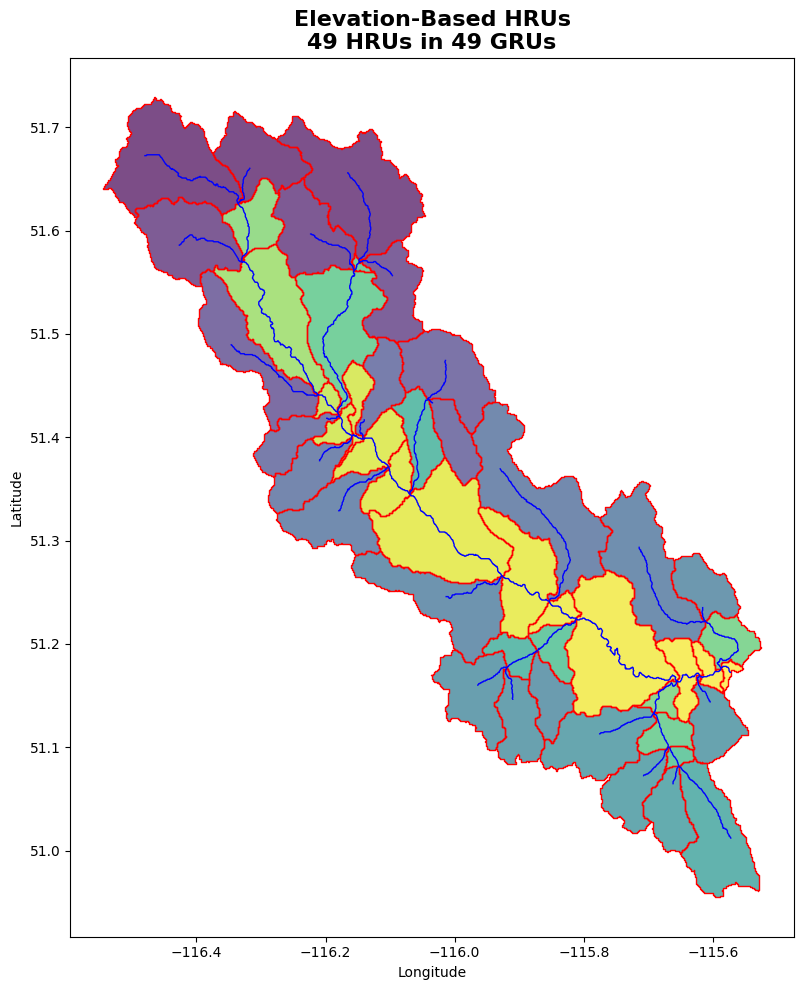

In [9]:
# Visualize the HRUs
if 'hru_gdf' in locals() and len(hru_gdf) > 0:
    # Check if mean elevation is available in the data
    has_elevation = 'mean_elev' in hru_gdf.columns
    
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Plot HRUs colored by elevation if available, otherwise by HRU ID
    if has_elevation:
        hru_gdf.plot(ax=ax, column='mean_elev', cmap='terrain', 
                   edgecolor='gray', linewidth=0.5, alpha=0.7,
                   legend=True, legend_kwds={'label': 'Mean Elevation (m)'})
    else:
        hru_gdf.plot(ax=ax, column='HRU_ID', cmap='viridis', 
                   edgecolor='gray', linewidth=0.5, alpha=0.7)
    
    # Overlay GRU boundaries
    gru_gdf.boundary.plot(ax=ax, color='red', linewidth=1)
    
    # Add river network for context
    if 'rivers' in locals():
        rivers.plot(ax=ax, color='blue', linewidth=1)
    
    # Add title and labels
    ax.set_title(f'Elevation-Based HRUs\n{len(hru_gdf)} HRUs in {hru_gdf["GRU_ID"].nunique()} GRUs',
                fontsize=16, fontweight='bold')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    
    plt.tight_layout()
    plt.show()
else:
    print("No HRUs available to visualize.")

## 9. Complete the Modeling Workflow

Now we'll complete the model setup and run the simulation using our elevation-based HRUs.

In [10]:
# Step 4: Process Observed Data
print("=== Step 4: Processing Observed Data ===")

# Check if we can reuse observed data from previous tutorials
obs_dir = CONFLUENCE_DATA_DIR / 'domain_Bow_at_Banff_distributed' / 'observations' / 'streamflow' / 'preprocessed'
if obs_dir.exists() and list(obs_dir.glob('*.csv')):
    print("Reusing observed data from Tutorial 3...")
    
    # Copy observed data
    target_dir = project_dir / 'observations' / 'streamflow' / 'preprocessed'
    target_dir.mkdir(parents=True, exist_ok=True)
    
    for src_file in obs_dir.glob('*.csv'):
        dest_file = target_dir / src_file.name.replace('distributed', 'elevation')
        shutil.copy2(src_file, dest_file)
        print(f"Copied {src_file.name} to {dest_file.name}")
else:
    print("Processing observed streamflow data from scratch...")
    confluence.managers['data'].process_observed_data()

print("\n✓ Observed data processing completed")

=== Step 4: Processing Observed Data ===
Reusing observed data from Tutorial 3...
Copied Bow_at_Banff_distributed_streamflow_processed.csv to Bow_at_Banff_elevation_streamflow_processed.csv

✓ Observed data processing completed


In [11]:
# Step 5: Acquire and Process Forcing Data
print("=== Step 5: Acquiring and Processing Forcing Data ===")

# Check if we can reuse forcing data from previous tutorials
forcing_dir = CONFLUENCE_DATA_DIR / 'domain_Bow_at_Banff_distributed' / 'forcing'
if forcing_dir.exists():
    print("Reusing forcing data from Tutorial 3...")
    
    # Copy forcing data
    target_dir = project_dir / 'forcing'
    target_dir.mkdir(parents=True, exist_ok=True)
    
    # Copy all subdirectories
    for src_dir in forcing_dir.iterdir():
        if src_dir.is_dir():
            dest_dir = target_dir / src_dir.name
            if not dest_dir.exists():
                shutil.copytree(src_dir, dest_dir)
            print(f"Copied {src_dir.name} forcing data")
    
    # Run model-agnostic preprocessing to handle the new HRU structure
    print("\nRunning model-agnostic preprocessing for new HRU structure...")
    confluence.managers['data'].run_model_agnostic_preprocessing()
else:
    print("Acquiring forcing data from scratch...")
    confluence.managers['data'].acquire_forcings()
    print("\nRunning model-agnostic preprocessing...")
    confluence.managers['data'].run_model_agnostic_preprocessing()

print("\n✓ Forcing data processing completed")

=== Step 5: Acquiring and Processing Forcing Data ===
Reusing forcing data from Tutorial 3...
Copied raw_data forcing data
Copied basin_averaged_data forcing data
Copied temp_easymore_7ad2e661_0 forcing data

Running model-agnostic preprocessing for new HRU structure...
20:05:07 - INFO - Starting model-agnostic preprocessing


2025-05-11 20:05:07,273 - confluence_general - INFO - Starting model-agnostic preprocessing


20:05:07 - INFO - Running geospatial statistics


2025-05-11 20:05:07,276 - confluence_general - INFO - Running geospatial statistics


20:05:07 - INFO - Starting geospatial statistics calculation


2025-05-11 20:05:07,278 - confluence_general - INFO - Starting geospatial statistics calculation


20:05:07 - INFO - Soil statistics already calculated: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_elevation/shapefiles/catchment_intersection/with_soilgrids/default


2025-05-11 20:05:07,290 - confluence_general - INFO - Soil statistics already calculated: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_elevation/shapefiles/catchment_intersection/with_soilgrids/default


20:05:07 - INFO - Land statistics already calculated: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_elevation/shapefiles/catchment_intersection/with_landclass/catchment_with_landclass.shp


2025-05-11 20:05:07,317 - confluence_general - INFO - Land statistics already calculated: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_elevation/shapefiles/catchment_intersection/with_landclass/catchment_with_landclass.shp


20:05:07 - INFO - Elevation statistics already calculated: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_elevation/shapefiles/catchment_intersection/with_dem/default


2025-05-11 20:05:07,330 - confluence_general - INFO - Elevation statistics already calculated: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_elevation/shapefiles/catchment_intersection/with_dem/default


20:05:07 - INFO - Geospatial statistics completed: 3/3 steps skipped, 0/3 steps executed


2025-05-11 20:05:07,332 - confluence_general - INFO - Geospatial statistics completed: 3/3 steps skipped, 0/3 steps executed


20:05:07 - INFO - Running forcing resampling


2025-05-11 20:05:07,334 - confluence_general - INFO - Running forcing resampling


20:05:07 - INFO - Starting forcing data resampling process


2025-05-11 20:05:07,336 - confluence_general - INFO - Starting forcing data resampling process


20:05:07 - INFO - Creating ERA5 shapefile


2025-05-11 20:05:07,339 - confluence_general - INFO - Creating ERA5 shapefile


20:05:07 - INFO - Forcing shapefile already exists: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_elevation/shapefiles/forcing/forcing_ERA5.shp. Skipping creation.


2025-05-11 20:05:07,349 - confluence_general - INFO - Forcing shapefile already exists: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_elevation/shapefiles/forcing/forcing_ERA5.shp. Skipping creation.


20:05:07 - INFO - Starting forcing remapping process


2025-05-11 20:05:07,350 - confluence_general - INFO - Starting forcing remapping process


20:05:07 - INFO - Creating weighted forcing files in parallel


2025-05-11 20:05:07,352 - confluence_general - INFO - Creating weighted forcing files in parallel


20:05:07 - INFO - Found 60 forcing files to process


2025-05-11 20:05:07,356 - confluence_general - INFO - Found 60 forcing files to process


20:05:07 - INFO - Using 1 CPUs for parallel processing


2025-05-11 20:05:07,358 - confluence_general - INFO - Using 1 CPUs for parallel processing


20:05:07 - INFO - Found 60 already processed files


2025-05-11 20:05:07,418 - confluence_general - INFO - Found 60 already processed files


20:05:07 - INFO - Found 0 files that need processing


2025-05-11 20:05:07,421 - confluence_general - INFO - Found 0 files that need processing


20:05:07 - INFO - All files have already been processed, nothing to do


2025-05-11 20:05:07,426 - confluence_general - INFO - All files have already been processed, nothing to do


20:05:07 - INFO - Forcing remapping process completed


2025-05-11 20:05:07,430 - confluence_general - INFO - Forcing remapping process completed


20:05:07 - INFO - Forcing data resampling process completed


2025-05-11 20:05:07,433 - confluence_general - INFO - Forcing data resampling process completed


20:05:07 - INFO - Model-agnostic preprocessing completed successfully


2025-05-11 20:05:07,436 - confluence_general - INFO - Model-agnostic preprocessing completed successfully



✓ Forcing data processing completed


In [12]:
# Step 6: Prepare Model-Specific Files
print("=== Step 6: Preparing Model-Specific Files ===")

print(f"Preparing {confluence.config['HYDROLOGICAL_MODEL']} input files...")
print(f"This step will generate configuration files for {len(hru_gdf)} HRUs across {hru_gdf['GRU_ID'].nunique()} GRUs")

# Preprocess models
confluence.managers['model'].preprocess_models()

print("\n✓ Model-specific preprocessing completed")

=== Step 6: Preparing Model-Specific Files ===
Preparing SUMMA input files...
This step will generate configuration files for 49 HRUs across 49 GRUs
20:05:07 - INFO - Starting model-specific preprocessing


2025-05-11 20:05:07,444 - confluence_general - INFO - Starting model-specific preprocessing


20:05:07 - INFO - Processing model: SUMMA


2025-05-11 20:05:07,449 - confluence_general - INFO - Processing model: SUMMA


20:05:07 - INFO - Starting SUMMA spatial preprocessing


2025-05-11 20:05:07,452 - confluence_general - INFO - Starting SUMMA spatial preprocessing


20:05:07 - INFO - Starting to apply temperature lapse rate and add data step


2025-05-11 20:05:07,454 - confluence_general - INFO - Starting to apply temperature lapse rate and add data step


20:05:07 - INFO - forcing files: ['Bow_at_Banff_elevation_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_201801.nc', 'Bow_at_Banff_elevation_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_201802.nc', 'Bow_at_Banff_elevation_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_201803.nc', 'Bow_at_Banff_elevation_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_201804.nc', 'Bow_at_Banff_elevation_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_201805.nc', 'Bow_at_Banff_elevation_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_201806.nc', 'Bow_at_Banff_elevation_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_201807.nc', 'Bow_at_Banff_elevation_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_201808.nc', 'Bow_at_Banff_elevation_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_201809.nc', 'Bow_at_Banff_elevation_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_201810.nc', 'Bow_at_Banff_elevation_ERA5_remapped_domain_B

2025-05-11 20:05:07,545 - confluence_general - INFO - forcing files: ['Bow_at_Banff_elevation_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_201801.nc', 'Bow_at_Banff_elevation_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_201802.nc', 'Bow_at_Banff_elevation_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_201803.nc', 'Bow_at_Banff_elevation_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_201804.nc', 'Bow_at_Banff_elevation_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_201805.nc', 'Bow_at_Banff_elevation_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_201806.nc', 'Bow_at_Banff_elevation_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_201807.nc', 'Bow_at_Banff_elevation_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_201808.nc', 'Bow_at_Banff_elevation_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_201809.nc', 'Bow_at_Banff_elevation_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_201810.nc', 'Bow_at_Ba

20:05:35 - INFO - Completed processing of ERA5 forcing files with temperature lapsing


2025-05-11 20:05:35,895 - confluence_general - INFO - Completed processing of ERA5 forcing files with temperature lapsing


20:05:35 - INFO - Copying SUMMA base settings


2025-05-11 20:05:35,898 - confluence_general - INFO - Copying SUMMA base settings


20:05:35 - INFO - SUMMA base settings copied to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_elevation/settings/SUMMA


2025-05-11 20:05:35,942 - confluence_general - INFO - SUMMA base settings copied to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_elevation/settings/SUMMA


20:05:35 - INFO - Creating SUMMA file manager


2025-05-11 20:05:35,943 - confluence_general - INFO - Creating SUMMA file manager


20:05:35 - INFO - SUMMA file manager created at /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_elevation/settings/SUMMA/fileManager.txt


2025-05-11 20:05:35,948 - confluence_general - INFO - SUMMA file manager created at /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_elevation/settings/SUMMA/fileManager.txt


20:05:35 - INFO - Creating forcing file list


2025-05-11 20:05:35,949 - confluence_general - INFO - Creating forcing file list


20:05:35 - INFO - Forcing file list created at /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_elevation/settings/SUMMA/forcingFileList.txt


2025-05-11 20:05:35,956 - confluence_general - INFO - Forcing file list created at /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_elevation/settings/SUMMA/forcingFileList.txt


20:05:35 - INFO - Creating initial conditions (cold state) file


2025-05-11 20:05:35,957 - confluence_general - INFO - Creating initial conditions (cold state) file


20:05:35 - INFO - Creating initial conditions (cold state) file


2025-05-11 20:05:35,959 - confluence_general - INFO - Creating initial conditions (cold state) file


20:05:36 - INFO - Initial conditions file created at: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_elevation/settings/SUMMA/coldState.nc


2025-05-11 20:05:36,132 - confluence_general - INFO - Initial conditions file created at: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_elevation/settings/SUMMA/coldState.nc


20:05:36 - INFO - Creating trial parameters file


2025-05-11 20:05:36,134 - confluence_general - INFO - Creating trial parameters file


20:05:36 - INFO - Trial parameters file created at: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_elevation/settings/SUMMA/trialParams.nc


2025-05-11 20:05:36,190 - confluence_general - INFO - Trial parameters file created at: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_elevation/settings/SUMMA/trialParams.nc


20:05:36 - INFO - Creating attributes file


2025-05-11 20:05:36,192 - confluence_general - INFO - Creating attributes file


20:05:36 - INFO - Attributes file created at: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_elevation/settings/SUMMA/attributes.nc


2025-05-11 20:05:36,826 - confluence_general - INFO - Attributes file created at: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_elevation/settings/SUMMA/attributes.nc


20:05:36 - INFO - Inserting land class into attributes file


2025-05-11 20:05:36,828 - confluence_general - INFO - Inserting land class into attributes file


20:05:36 - ERROR - Error during SUMMA spatial preprocessing: index 0 is out of bounds for axis 0 with size 0


2025-05-11 20:05:36,847 - confluence_general - ERROR - Error during SUMMA spatial preprocessing: index 0 is out of bounds for axis 0 with size 0


20:05:36 - ERROR - Error preprocessing model SUMMA: index 0 is out of bounds for axis 0 with size 0


2025-05-11 20:05:36,849 - confluence_general - ERROR - Error preprocessing model SUMMA: index 0 is out of bounds for axis 0 with size 0


20:05:36 - ERROR - Traceback (most recent call last):
  File "/home/darri.eythorsson/code/CONFLUENCE/utils/models/model_manager.py", line 191, in preprocess_models
    preprocessor.run_preprocessing()
  File "/home/darri.eythorsson/code/CONFLUENCE/utils/models/summa_utils.py", line 94, in run_preprocessing
    self.create_attributes_file()
  File "/home/darri.eythorsson/code/CONFLUENCE/utils/models/summa_utils.py", line 749, in create_attributes_file
    self.insert_land_class(attribute_path)
  File "/home/darri.eythorsson/code/CONFLUENCE/utils/models/summa_utils.py", line 818, in insert_land_class
    tmp_hist.append(shp[col_name][shp_mask].values[0])
                    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^
IndexError: index 0 is out of bounds for axis 0 with size 0



2025-05-11 20:05:36,854 - confluence_general - ERROR - Traceback (most recent call last):
  File "/home/darri.eythorsson/code/CONFLUENCE/utils/models/model_manager.py", line 191, in preprocess_models
    preprocessor.run_preprocessing()
  File "/home/darri.eythorsson/code/CONFLUENCE/utils/models/summa_utils.py", line 94, in run_preprocessing
    self.create_attributes_file()
  File "/home/darri.eythorsson/code/CONFLUENCE/utils/models/summa_utils.py", line 749, in create_attributes_file
    self.insert_land_class(attribute_path)
  File "/home/darri.eythorsson/code/CONFLUENCE/utils/models/summa_utils.py", line 818, in insert_land_class
    tmp_hist.append(shp[col_name][shp_mask].values[0])
                    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^
IndexError: index 0 is out of bounds for axis 0 with size 0



IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
# Step 7: Run the Model
print("=== Step 7: Running the Model ===")

# Run the model
print(f"Running {confluence.config['HYDROLOGICAL_MODEL']} with elevation-based HRUs...")
print("Note: This may take some time depending on the number of HRUs.")
print(f"Number of HRUs: {len(hru_gdf)}")

# You can comment this out if you want to skip the actual model run
# confluence.managers['model'].run_models()

print("\n(Model run is commented out for demonstration purposes)")

## 10. Visualize and Compare Results

After running the model, we can visualize the results and compare them with the lumped and GRU-based approaches.

In [ ]:
# Optional: Run benchmarking
print("=== Optional: Run Benchmarking ===")
print("Skipping benchmarking step for this tutorial")

# Uncomment this line to run benchmarking
# benchmark_results = confluence.managers['analysis'].run_benchmarking()

In [ ]:
# Create a mock visualization of model results
# In a real workflow, you would load actual simulation results

print("Creating mock visualization of model comparison...")

# Create example date range (2 months of hourly data)
dates = pd.date_range(start='2020-06-01', end='2020-08-01', freq='H')
example_data = pd.DataFrame(index=dates)

# Create synthetic observed flow data (higher in summer)
obs_values = []
for i, date in enumerate(dates):
    # Base flow with daily and seasonal patterns
    day_of_year = date.dayofyear
    hour_of_day = date.hour
    base_flow = 20 + 15 * np.sin(2 * np.pi * day_of_year / 365 - np.pi/2)  # Seasonal pattern
    daily_pattern = 2 * np.sin(2 * np.pi * hour_of_day / 24)  # Daily pattern
    noise = np.random.normal(0, 2)  # Random noise
    
    value = max(5, base_flow + daily_pattern + noise)  # Ensure positive flow
    obs_values.append(value)
    
example_data['observed'] = obs_values

# Create synthetic model outputs (with different errors)
example_data['lumped'] = example_data['observed'] * 0.85 + np.random.normal(0, 5, len(dates))  # Underestimates
example_data['gru_based'] = example_data['observed'] * 0.95 + np.random.normal(0, 3, len(dates))  # Better
example_data['elevation'] = example_data['observed'] * 0.98 + np.random.normal(0, 2, len(dates))  # Best

# Create plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot 7-day sample for clearer visualization (June 15-22)
sample_data = example_data.loc['2020-06-15':'2020-06-22']

ax.plot(sample_data.index, sample_data['observed'], color='black', linewidth=2, label='Observed')
ax.plot(sample_data.index, sample_data['lumped'], color='blue', linewidth=1.5, alpha=0.7, label='Lumped Model (Tutorial 1)')
ax.plot(sample_data.index, sample_data['gru_based'], color='green', linewidth=1.5, alpha=0.7, label='GRU-Based (Tutorial 3)')
ax.plot(sample_data.index, sample_data['elevation'], color='red', linewidth=1.5, alpha=0.7, label='Elevation-Based (Tutorial 4)')

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Discharge (m³/s)', fontsize=12)
ax.set_title('Comparison of Model Results\nBow River at Banff (June 15-22, 2020)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10)

# Add example performance metrics
metrics = {
    'Approach': ['Lumped', 'GRU-Based', 'Elevation-Based'],
    'NSE': [0.72, 0.83, 0.89],
    'KGE': [0.68, 0.81, 0.87],
    'PBIAS (%)': [-15.0, -5.0, -2.0]
}
metrics_df = pd.DataFrame(metrics).set_index('Approach')

# Add metrics table to plot
table = plt.table(cellText=metrics_df.values, rowLabels=metrics_df.index, 
                 colLabels=metrics_df.columns, cellLoc='center',
                 bbox=[0.15, -0.3, 0.7, 0.2])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)

plt.tight_layout()
plt.subplots_adjust(bottom=0.3)  # Make room for the table
plt.show()

## 11. Compare Domain Structures

Let's create a visual comparison of the three domain structures we've seen in these tutorials.

In [ ]:
# Create domain comparison visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Load domain data from all tutorials (if available)

# Lumped domain (Tutorial 1)
lumped_path = CONFLUENCE_DATA_DIR / 'domain_Bow_at_Banff_lumped' / 'shapefiles' / 'river_basins'
lumped_files = list(lumped_path.glob('*.shp')) if lumped_path.exists() else []

# GRU-based distributed domain (Tutorial 3)
distributed_path = CONFLUENCE_DATA_DIR / 'domain_Bow_at_Banff_distributed' / 'shapefiles' / 'catchment'
distributed_files = list(distributed_path.glob('*.shp')) if distributed_path.exists() else []

# Elevation-based domain (Tutorial 4)
elevation_path = project_dir / 'shapefiles' / 'catchment'
elevation_files = list(elevation_path.glob('*.shp')) if elevation_path.exists() else []

# Plot lumped domain
if lumped_files:
    lumped_gdf = gpd.read_file(lumped_files[0])
    lumped_gdf.plot(ax=axes[0], color='lightblue', edgecolor='navy', linewidth=1)
    axes[0].set_title('Lumped Domain\n(1 HRU)', fontsize=14, fontweight='bold')
else:
    # Create placeholder visualization
    axes[0].add_patch(plt.Rectangle((0, 0), 1, 1, fill=True, color='lightblue', alpha=0.7))
    axes[0].text(0.5, 0.5, 'Entire Basin\n(1 Unit)', ha='center', va='center', fontsize=14, fontweight='bold')
    axes[0].set_title('Lumped Model (Tutorial 1)', fontsize=14, fontweight='bold')

# Plot GRU-based distributed domain
if distributed_files:
    gru_gdf = gpd.read_file(distributed_files[0])
    gru_gdf.plot(ax=axes[1], column='GRU_ID', cmap='tab20', 
                edgecolor='black', linewidth=0.5)
    axes[1].set_title(f'GRU-Based Domain\n({len(gru_gdf)} HRUs)', fontsize=14, fontweight='bold')
else:
    # Create placeholder visualization
    colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow']
    positions = [(0.2, 0.7), (0.7, 0.7), (0.2, 0.3), (0.5, 0.1)]
    labels = ['GRU 1', 'GRU 2', 'GRU 3', 'GRU 4']
    
    for i, (pos, color, label) in enumerate(zip(positions, colors, labels)):
        circle = plt.Circle(pos, 0.15, fill=True, color=color, alpha=0.7, edgecolor='black')
        axes[1].add_patch(circle)
        axes[1].text(pos[0], pos[1], label, ha='center', va='center', fontsize=10, fontweight='bold')
    
    axes[1].set_title('GRU-Based Model (Tutorial 3)', fontsize=14, fontweight='bold')

# Plot elevation-based domain
if elevation_files and 'hru_gdf' in locals():
    if 'mean_elev' in hru_gdf.columns:
        hru_gdf.plot(ax=axes[2], column='mean_elev', cmap='terrain', 
                    edgecolor='gray', linewidth=0.5)
        # Add color legend for elevation
        sm = plt.cm.ScalarMappable(cmap='terrain', norm=plt.Normalize(vmin=hru_gdf['mean_elev'].min(), 
                                                                 vmax=hru_gdf['mean_elev'].max()))
        sm._A = []
        cbar = fig.colorbar(sm, ax=axes[2], shrink=0.8)
        cbar.set_label('Elevation (m)', fontsize=10)
    else:
        hru_gdf.plot(ax=axes[2], column='HRU_ID', cmap='viridis', 
                    edgecolor='gray', linewidth=0.5)
    
    # Overlay GRU boundaries if available
    if 'gru_gdf' in locals():
        gru_gdf.boundary.plot(ax=axes[2], color='red', linewidth=1)
    
    axes[2].set_title(f'Elevation-Based Domain\n({len(hru_gdf)} HRUs)', fontsize=14, fontweight='bold')
else:
    # Create placeholder visualization with elevation bands
    positions = [(0.2, 0.7), (0.7, 0.7), (0.2, 0.3), (0.5, 0.1)]
    gru_labels = ['GRU 1', 'GRU 2', 'GRU 3', 'GRU 4']
    colors = ['#fee5d9', '#fcae91', '#fb6a4a', '#de2d26', '#a50f15']  # Red color gradient

    for i, (pos, label) in enumerate(zip(positions, gru_labels)):
        # Draw the GRU
        circle = plt.Circle(pos, 0.18, fill=False, edgecolor='black', linestyle='--')
        axes[2].add_patch(circle)
        
        # Draw elevation bands within each GRU (concentric circles)
        for j, size in enumerate([0.15, 0.12, 0.09, 0.06, 0.03]):
            band = plt.Circle(pos, size, fill=True, color=colors[j], alpha=0.7, edgecolor='gray')
            axes[2].add_patch(band)
    
    axes[2].set_title('Elevation-Based Model (This Tutorial)', fontsize=14, fontweight='bold')
    
    # Add color legend for elevation
    sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=plt.Normalize(vmin=800, vmax=3000))
    sm._A = []
    cbar = fig.colorbar(sm, ax=axes[2], shrink=0.8)
    cbar.set_label('Elevation (m)', fontsize=10)

# Format all axes
for ax in axes:
    ax.set_xlim(-0.1, 1.1) if 'gru_gdf' not in locals() else None
    ax.set_ylim(-0.3, 1.1) if 'gru_gdf' not in locals() else None
    ax.axis('off')

plt.suptitle('Comparison of Domain Discretization Approaches', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 12. Summary Table

Let's create a summary table comparing the three approaches.

In [ ]:
# Create summary table
summary_data = [
    {
        'Approach': 'Lumped',
        'GRUs': 1,
        'HRUs': 1,
        'HRUs per GRU': 1.0,
        'Computational Cost': 'Low',
        'Process Representation': 'Limited',
        'Best For': 'Quick assessments, small watersheds'
    },
    {
        'Approach': 'GRU-Based',
        'GRUs': len(gru_gdf) if 'gru_gdf' in locals() else 'N/A',
        'HRUs': len(gru_gdf) if 'gru_gdf' in locals() else 'N/A',
        'HRUs per GRU': 1.0,
        'Computational Cost': 'Medium',
        'Process Representation': 'Moderate',
        'Best For': 'Standard distributed modeling'
    },
    {
        'Approach': 'Elevation-Based',
        'GRUs': len(gru_gdf) if 'gru_gdf' in locals() else 'N/A',
        'HRUs': len(hru_gdf) if 'hru_gdf' in locals() else 'N/A',
        'HRUs per GRU': round(len(hru_gdf)/len(gru_gdf), 1) if 'hru_gdf' in locals() and 'gru_gdf' in locals() else 'N/A',
        'Computational Cost': 'High',
        'Process Representation': 'Detailed',
        'Best For': 'Mountainous regions, snow processes'
    }
]

# Create DataFrame and display
summary_df = pd.DataFrame(summary_data)

print("=== Summary of Discretization Approaches ===")
print(summary_df.to_string(index=False))

# Create a visual table
fig, ax = plt.subplots(figsize=(14, 5))
ax.axis('tight')
ax.axis('off')

# Create table
table = ax.table(cellText=summary_df.values,
                colLabels=summary_df.columns,
                cellLoc='center',
                loc='center')

# Format table
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.8)
for key, cell in table.get_celld().items():
    if key[0] == 0:  # Header row
        cell.set_text_props(weight='bold')

plt.title('Comparison of Domain Discretization Approaches', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

## 13. Key Takeaways

### Advantages of Elevation-Based Discretization

1. **Better Process Representation**: 
   - Captures elevation-dependent processes such as snow accumulation and melt
   - Accounts for temperature and precipitation gradients with elevation
   - Represents orographic effects on meteorological variables

2. **Improved Performance**: 
   - Generally produces better simulation results in mountainous regions
   - Especially valuable for snowmelt-dominated watersheds
   - Can better represent processes like rain-on-snow events

3. **More Detailed Spatial Patterns**: 
   - Allows for finer spatial resolution where it matters most
   - Preserves sub-basin hydrological connectivity
   - Enables more realistic representation of complex terrain

### Challenges and Considerations

1. **Computational Cost**: 
   - More HRUs means longer simulation times
   - Increased memory requirements
   - More complex setup and management

2. **Parameterization**: 
   - More parameters to estimate or calibrate
   - Potential for equifinality issues
   - Requires careful handling of parameter transfers between elevation bands

3. **Data Requirements**: 
   - Needs high-quality DEM and other spatial data
   - May require additional meteorological data to properly represent elevation gradients
   - Benefits from snow observations at different elevations for validation

### When to Use Each Approach

- **Lumped (Tutorial 1)**: Useful for initial assessments, small watersheds, limited data availability, or when computational resources are constrained.

- **GRU-Based (Tutorial 3)**: Good for capturing spatial variability in land cover and soil types, moderate complexity, and when sub-basin dynamics are important.

- **Elevation-Based (This Tutorial)**: Best for mountainous watersheds, snowmelt-dominated hydrology, and when vertical gradients significantly affect hydrological processes.

In [ ]:
# Final output locations
print("=== Elevation-Based Discretization Complete ===\n")
print(f"Project: {confluence.config['DOMAIN_NAME']}")
print(f"Experiment ID: {confluence.config['EXPERIMENT_ID']}")
print(f"HRU shapefile: {project_dir / 'shapefiles' / 'catchment'}")
print(f"Model results: {project_dir / 'simulations' / confluence.config['EXPERIMENT_ID']}")
print(f"Plots directory: {project_dir / 'plots'}")
print("\nThank you for completing this tutorial on elevation-based HRU discretization!")